## Radio Frequency (RF) Signal Image Classification

#### Dataset
- The [dataset](https://www.kaggle.com/datasets/halcy0nic/radio-frequecy-rf-signal-image-classification/data) contains images of [waterfall plots](https://en.wikipedia.org/wiki/Waterfall_plot), which were generated by spectrum analyzer.
- Waterfall plot is a type of visualization used to display frequency content of a signal over time. The color in a waterfall plot represents the signal strength at a particular frequency and time. The specific color mapping used can vary, but typically, warmer colors (like red and orange) indicate higher signal strength, while cooler colors (like blue and green) indicate lower signal strength.

#### CUDA Setup & Check
- Download & install latest [NVIDIA Drivers](https://www.nvidia.com/en-us/drivers/) & [CUDA Toolkit](https://developer.nvidia.com/cuda-downloads)
- Command to check NVIDIA GPU Driver Version: `nvidia-smi`. This also monitors monitor GPU usage in real-time.
- Command to check CUDA Version: `nvcc --version`
- Install PyTorch with CUDA support: `pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118`

In [1]:
# Check CUDA Version in Python:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.backends.cudnn.enabled)

True
1
NVIDIA RTX A4000
True


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from minio import Minio
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv
from torchvision.models import ResNet18_Weights

# Load environment variables
load_dotenv()

True

In [3]:
# Set Seeds for Reproducibility
seed = 30
torch.manual_seed(seed) # Set the seed for generating random numbers on the CPU. By setting this seed, you ensure that the random numbers generated by PyTorch on the CPU are reproducible.
torch.cuda.manual_seed(seed) # Set the seed for generating random numbers on the GPU. By setting this seed, you ensure that the random numbers generated by PyTorch on the GPU are reproducible.
torch.backends.cudnn.deterministic = True # Ensure that the CUDA backend (cuDNN) uses deterministic algorithms. This is important for reproducibility, as some algorithms in cuDNN can have non-deterministic behavior.

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# MinIO Configuration
minio_client = Minio(
    os.getenv("MINIO_IP"),
    access_key=os.getenv("MINIO_ACCESS_KEY"),
    secret_key=os.getenv("MINIO_SECRET_KEY"),
    secure=False
)

bucket_name = os.getenv("MINIO_BUCKET_NAME")
prefix = os.getenv("PREFIX")
local_tmp_dir = os.getenv("LOCAL_TMP_DIR")
os.makedirs(local_tmp_dir, exist_ok=True)

# Download images from MinIO
def download_images_from_minio():
    objects = minio_client.list_objects(bucket_name, prefix=prefix, recursive=True)
    for obj in objects:
        if obj.object_name.endswith(('.jpg', '.png', '.jpeg')):
            response = minio_client.get_object(bucket_name, obj.object_name)
            
            # Create subdirectories to match MinIO structure
            relative_path = obj.object_name[len(prefix):]  # Remove prefix
            class_folder = os.path.join(local_tmp_dir, os.path.dirname(relative_path))
            os.makedirs(class_folder, exist_ok=True)
            
            img_path = os.path.join(local_tmp_dir, relative_path)
            with open(img_path, 'wb') as file_data:
                file_data.write(response.read())

download_images_from_minio()

In [10]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for CNN
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=local_tmp_dir, transform=transform)
print(dataset)

train_size = int(0.8 * len(dataset))
print(train_size)

test_size = len(dataset) - train_size
print(test_size)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 3620
    Root location: ./minio_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
2896
724


In [13]:
# Define CNN Model
class RFSignalCNN(nn.Module):
    def __init__(self, num_classes):
        super(RFSignalCNN, self).__init__()
        # self.model = models.resnet18(pretrained=True)
        # Initalize with pre-trained weidghts
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes) #  Replace the final fully connected layer of ResNet-18 to match the number of classes in the dataset. 
    
    def forward(self, x):
        return self.model(x)

# Initialize model
# dataset.classes = ['RS41-Radiosonde', 'Radioteletype', 'ads-b', 'airband', 'ais', 'automatic-picture-transmission', 'bluetooth', 'cellular', 'digital-audio-broadcasting', 'digital-speech-decoder', 'fm', 'lora', 'morse', 'on-off-keying', 'packet', 'pocsag', 'remote-keyless-entry', 'sstv', 'vor', 'wifi']
num_classes = len(dataset.classes)
print(num_classes)
model = RFSignalCNN(num_classes).to(device) # Initialize the RFSignalCNN model and moves it to the specified device (CPUR/GPU) for training & inference (model & data need to be on the same device)
print(model)

20
RFSignalCNN(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [14]:
# Verify your model and data are on the GPU
print(next(model.parameters()).device)

cuda:0


In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # The loss function used to measure the model's performance. Used for multi-class classification.
optimizer = optim.Adam(model.parameters(), lr=0.001) # The optimization algorithm used to update the model's parameters. Update the model's parameters with a learning rate of 0.001.

# Define the training function - Train the RFSignalCNN model on the provided training data for the specified number of epochs, updating the model's parameters to minimize the loss.
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train() # # Set the model to training mode
    for epoch in range(num_epochs): # Loop over the number of epochs. Each epoch represents one complete pass through the training dataset.
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # Move the input data and labels to the specified device (CPU or GPU).

            optimizer.zero_grad()  # Zero the parameter gradients - Clear the gradients of all optimized parameters to prevent accumulation of gradients from multiple forward passes.
            outputs = model(images)  # Forward pass - Compute the model's predictions for the input data.
            loss = criterion(outputs, labels)  # Compute loss - Compute the loss between the model's predictions and the actual labels.
            loss.backward()  # Backward pass - Compute the gradients of the loss with respect to the model's parameters.
            optimizer.step()  # Update weights - Update the model's parameters based on the computed gradients.

            running_loss += loss.item() # Accumulate the loss for the current batch to compute the average loss for the epoch.
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}") # Compute the average loss for the epoch

train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.8467
Epoch 2/10, Loss: 0.3513
Epoch 3/10, Loss: 0.2981
Epoch 4/10, Loss: 0.1694
Epoch 5/10, Loss: 0.1533
Epoch 6/10, Loss: 0.1240
Epoch 7/10, Loss: 0.1087
Epoch 8/10, Loss: 0.0527
Epoch 9/10, Loss: 0.0435
Epoch 10/10, Loss: 0.0764


In [17]:
# Save the model's state dict
torch.save(model.state_dict(), 'trained_model.pth') # The state dictionary contains all the parameters (weights and biases) of the model. Saving the state dictionary allows us to save the trained model's parameters and load them later for inference or further training.

# To load the model
# model = YourModelClass()  # Make sure to define the same model structure
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  # Set to evaluation mode if necessary. In evaluation mode, certain layers like dropout and batch normalization behave differently compared to training mode. For example, dropout is disabled, and batch normalization uses running statistics instead of batch statistics. Setting the model to evaluation mode is important when you are using the model for inference.

RFSignalCNN(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [18]:
# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%") # Accuracy alone does not provide a complete picture of the model's performance, especially if the dataset is imbalanced. To get a more comprehensive evaluation, you should also consider metrics like precision, recall, and F1 score, as well as the confusion matrix.

evaluate_model(model, test_loader)

Test Accuracy: 96.13%


### Confusion Matrix

A confusion matrix is a table that is used to describe the performance of a classification model. It shows the number of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions.

### Precision, Recall, and F1 Score
- Precision: The ratio of correctly predicted positive observations to the total predicted positives. It answers the question: "Of all the instances that were predicted as positive, how many were actually positive?"
    - Precision = TP / (TP + FP)

- Recall (Sensitivity): The ratio of correctly predicted positive observations to the all observations in the actual class. It answers the question: "Of all the instances that were actually positive, how many were predicted as positive?"
    - Recall = TP / {TP + FN}
- F1 Score: The weighted average of Precision and Recall. It is useful when you need a balance between Precision and Recall.
    - F1 Score = (2 * Precision * Recall) / (Precision + Recall) 

### Summary
- High Precision: The model makes very few mistakes when predicting positive samples.
- High Recall: The model successfully identifies most of the actual positive samples.
- High F1 Score: The model maintains a good balance between precision and recall, making it reliable for classification tasks.

In [23]:
dataset.classes

['RS41-Radiosonde',
 'Radioteletype',
 'ads-b',
 'airband',
 'ais',
 'automatic-picture-transmission',
 'bluetooth',
 'cellular',
 'digital-audio-broadcasting',
 'digital-speech-decoder',
 'fm',
 'lora',
 'morse',
 'on-off-keying',
 'packet',
 'pocsag',
 'remote-keyless-entry',
 'sstv',
 'vor',
 'wifi']

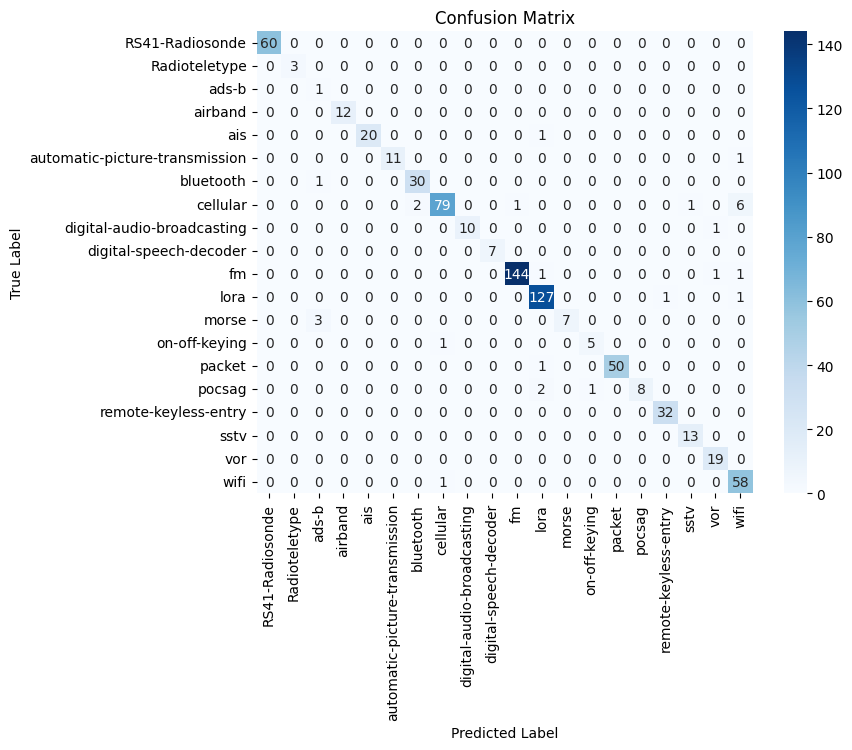

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy()) # Move the predictions back to the CPU and convert them to NumPy arrays
        all_labels.extend(labels.cpu().numpy()) # Move the labels back to the CPU and convert them to NumPy arrays

# Map Predicted Labels to Class Names: Convert the numeric labels to their corresponding class names
pred_class_names = [dataset.classes[pred] for pred in all_preds]
true_class_names = [dataset.classes[label] for label in all_labels]

# Compute confusion matrix - Provide a detailed breakdown of correct and incorrect predictions.
cm = confusion_matrix(true_class_names, pred_class_names, labels=dataset.classes)
# cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
# sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [18]:
# cm = confusion_matrix(all_labels, all_preds)
# print("Confusion Matrix:")
# print(cm)

In [ ]:
# Compute precision, recall, and F1 score
precision = precision_score(true_class_names, pred_class_names, average='weighted', labels=dataset.classes)
recall = recall_score(true_class_names, pred_class_names, average='weighted', labels=dataset.classes)
f1 = f1_score(true_class_names, pred_class_names, average='weighted', labels=dataset.classes)

print(f"Precision: {precision:.4f}") # Minimize FP - This means that 96.76% of the samples predicted as positive by the model are actually positive. A high precision indicates that the model has a low false positive rate.
print(f"Recall: {recall:.4f}") # Minimize FN - This means that 96.13% of the actual positive samples are correctly identified by the model. A high recall indicates that the model has a low false negative rate.
print(f"F1 Score: {f1:.4f}") # This indicates that your model has a good balance between precision and recall. An F1 score close to 1 indicates excellent model performance.

Precision: 0.9676
Recall: 0.9613
F1 Score: 0.9626


In [35]:
# Predict a new image
def predict_image(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return class_names[predicted.item()]

# Example usage:
new_image_path = "test/1.png" # Source: https://www.researchgate.net/figure/Waterfall-view-illustration-of-a-Wi-Fi-user-being-forced-to-switch-channel-by-strong_fig1_264597015
predicted_label = predict_image(new_image_path, model, transform, dataset.classes)
print(f"Predicted label: {predicted_label}")

new_image_path = "test/2.png" # Source: https://www.reddit.com/r/RTLSDR/comments/q2d0uc/what_are_these_signals_that_show_up_in_the/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button
predicted_label = predict_image(new_image_path, model, transform, dataset.classes)
print(f"Predicted label: {predicted_label}")

new_image_path = "test/3.png" # Source: https://ag1le.blogspot.com/2012/05/morse-code-decoding-machine-learning.html
predicted_label = predict_image(new_image_path, model, transform, dataset.classes)
print(f"Predicted label: {predicted_label}")

new_image_path = "test/4.png" # Source: https://www.researchgate.net/figure/Spectral-waterfall-of-a-bluetooth-signal_fig4_371279160
predicted_label = predict_image(new_image_path, model, transform, dataset.classes)
print(f"Predicted label: {predicted_label}")


Predicted label: wifi
Predicted label: pocsag
Predicted label: bluetooth
Predicted label: cellular
